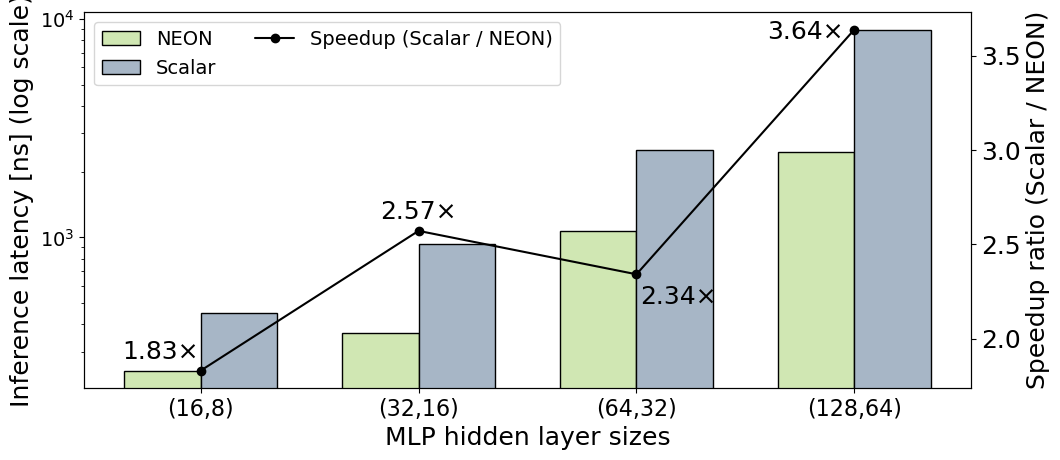

In [95]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- user-editable -----------------
dir_neon   = "/home/ubuntu/DoH_DGA_training/notebooks/lat_neon"
dir_scalar = "/home/ubuntu/DoH_DGA_training/notebooks/lat_scalar"
models = ['16', '32', '64', '128']   # subfolders to read
tsc_hz = 300254821                   # TSC frequency (Hz) for cycles -> ns conversion
take_head = 500                      # like your template: consider only first N rows
# -------------------------------------------------

# Mapping model folder -> label for hidden layers
model_label_map = {
    '16': '(16,8)',
    '32': '(32,16)',
    '64': '(64,32)',
    '128': '(128,64)',
}

def read_timings_file(base_dir, model):
    """Return path to timings_core0.csv inside model subfolder (or None)."""
    fp = os.path.join(base_dir, model, "timings_core0.csv")
    return fp if os.path.exists(fp) else None

def compute_mean_inference_ns(fp):
    """Read timings CSV and compute mean((feat_cycles + inf_cycles) -> ns) over first `take_head` rows."""
    df = pd.read_csv(fp).head(take_head)
    if 'feat_cycles' in df.columns and 'inf_cycles' in df.columns:
        cycles_sum = df['feat_cycles'].astype(float) + df['inf_cycles'].astype(float)
        cycles_sum = cycles_sum.replace([np.inf, -np.inf], np.nan).dropna()
        if cycles_sum.size == 0:
            return np.nan
        ns = (cycles_sum / float(tsc_hz)) * 1e9
        return float(ns.mean())
    if 'inf_cycles' in df.columns:
        cycles_sum = df['inf_cycles'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if cycles_sum.size == 0:
            return np.nan
        ns = (cycles_sum / float(tsc_hz)) * 1e9
        return float(ns.mean())
    for c in ['inf_ns', 'inference_ns', 'latency_ns', 'ns']:
        if c in df.columns:
            arr = df[c].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
            return float(arr.mean()) if arr.size > 0 else np.nan
    if 'cycles' in df.columns:
        cycles = df['cycles'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if cycles.size == 0:
            return np.nan
        ns = (cycles / float(tsc_hz)) * 1e9
        return float(ns.mean())
    return np.nan

# Collect means
labels = []
lat_neon_ns = []
lat_scalar_ns = []

for m in models:
    f_neon = read_timings_file(dir_neon, m)
    f_scalar = read_timings_file(dir_scalar, m)

    if f_neon is None or f_scalar is None:
        print(f"[WARN] Missing timings for model {m}")
        continue

    neon_mean = compute_mean_inference_ns(f_neon)
    scalar_mean = compute_mean_inference_ns(f_scalar)

    if np.isnan(neon_mean) or np.isnan(scalar_mean):
        print(f"[WARN] Skipping {m}: insufficient data")
        continue

    labels.append(m)
    lat_neon_ns.append(neon_mean)
    lat_scalar_ns.append(scalar_mean)

if not labels:
    raise SystemExit("No valid models read. Check folder layout and filenames.")

# compute speedup = SCALAR / NEON (since scalar is slower)
speedup = [s / n if n != 0 else np.nan for n, s in zip(lat_neon_ns, lat_scalar_ns)]

# ─── Plot (template styling) ───────────────────────────────────────────────────
colors = ['#d0e7b3', '#a7b6c6']  # [NEON-green, Scalar-blue]
x     = range(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(11, 5))

# NEON bars on the left, Scalar on the right
ax1.bar([i - width/2 for i in x], lat_neon_ns, width=width,
        label="NEON", color=colors[0], edgecolor="black", linewidth=1)
ax1.bar([i + width/2 for i in x], lat_scalar_ns, width=width,
        label="Scalar", color=colors[1], edgecolor="black", linewidth=1)

ax1.set_yscale('log')
ax1.set_xlabel("MLP hidden layer sizes", fontsize=18)
ax1.set_ylabel("Inference latency [ns] (log scale)", fontsize=18)
ax1.set_xticks(list(x))
ax1.set_xticklabels([model_label_map.get(l, l) for l in labels], fontsize=16)
ax1.tick_params(axis="y", labelsize=14)

# secondary axis for speedup
ax2 = ax1.twinx()
ax2.plot(x, speedup, marker="o", linestyle="-", color="black", label="Speedup (Scalar / NEON)")
ax2.set_ylabel("Speedup ratio (Scalar / NEON)", fontsize=18)
ax2.tick_params(axis="y", labelsize=18)

# custom label offsets
offsets = [(-29, 5), (0, 5), (30, -25), (-35, -10)]
for (xi, sp), ofs in zip(zip(x, speedup), offsets):
    ax2.annotate(f"{sp:.2f}×",
                 xy=(xi, sp), xytext=ofs,
                 textcoords="offset points",
                 ha="center", va="bottom", fontsize=18)

# combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left", fontsize=14, ncol=2)

plt.tight_layout()
plt.show()


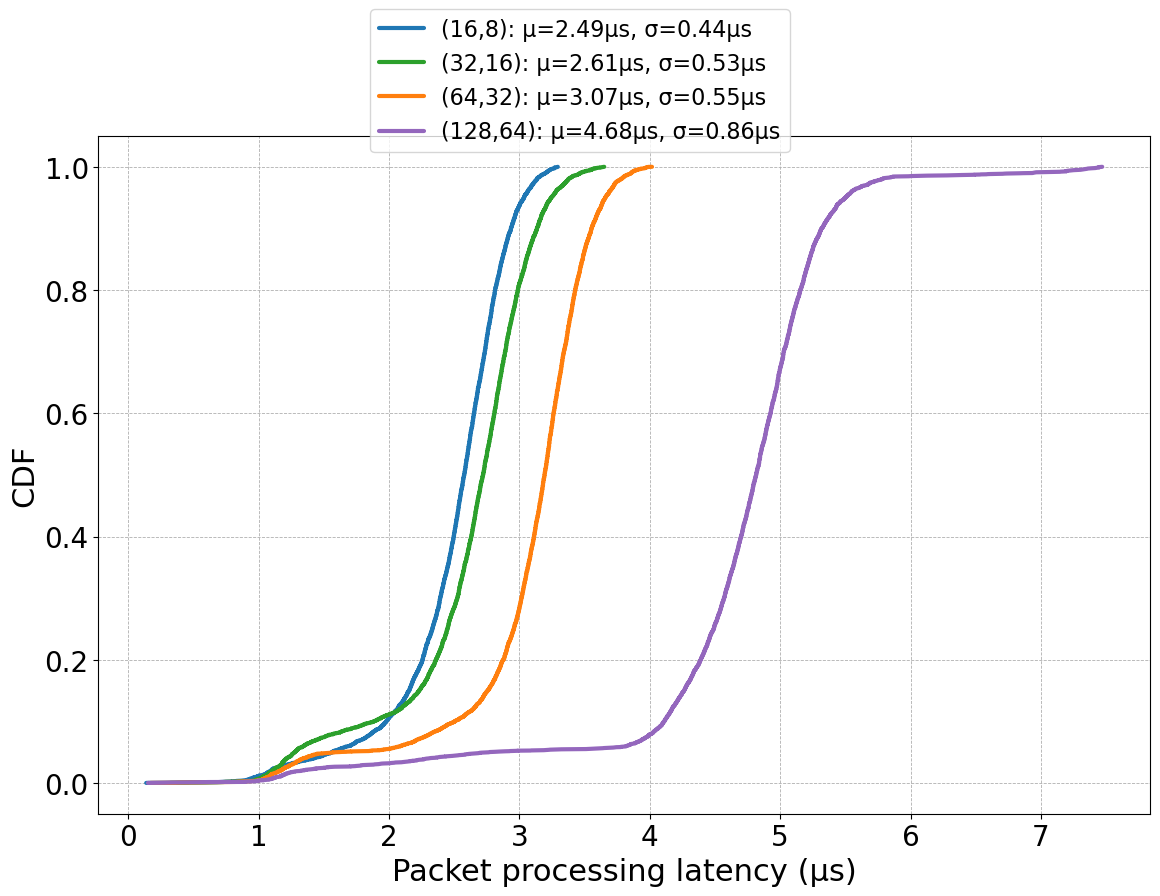


Summary (after removing >99th percentile):
  Model (16,8): mean = 2.4939 µs, std = 0.4375 µs
  Model (32,16): mean = 2.6099 µs, std = 0.5305 µs
  Model (64,32): mean = 3.0709 µs, std = 0.5511 µs
  Model (128,64): mean = 4.6805 µs, std = 0.8564 µs


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- user-editable ---
data_dir = "/home/ubuntu/DoH_DGA_training/notebooks/lat_neon"   # path containing subfolders 16,32,64,128
models = ['16', '32', '64', '128']
tsc_hz = 300254821   # TSC frequency (Hz)
percentile_cut = 99  # remove values above this percentile (set to 99 to remove top 1%)
# ----------------------

colors = {
    '16': '#1f77b4',
    '32': '#2ca02c',
    '64': '#ff7f0e',
    '128': '#9467bd',
}

model_label_map = {
    '16': '(16,8)',
    '32': '(32,16)',
    '64': '(64,32)',
    '128': '(128,64)'
}

fig, ax = plt.subplots(figsize=(12,9))
plt.rcParams.update({'font.size': 20})  # set font size to 20

summary_stats = {}

def read_latencies(folder):
    fp = os.path.join(folder, "latencies_core0.csv")
    if not os.path.exists(fp):
        print(f"[WARN] Missing latencies file: {fp}")
        return None
    return pd.read_csv(fp)

def cycles_to_us(cycles, tsc_hz):
    # cycles * (1e6 / tsc_hz) gives microseconds
    return np.asarray(cycles, dtype=float) * (1e6 / float(tsc_hz))

for model in models:
    folder = os.path.join(data_dir, model)
    lat_df = read_latencies(folder)
    if lat_df is None or lat_df.empty:
        print(f"[INFO] Skipping model {model} (no latencies file).")
        continue

    # ensure required columns exist
    if not {'sample', 'cycles', 'ns'}.issubset(lat_df.columns):
        print(f"[WARN] latencies_core0.csv in {folder} missing required columns. Skipping.")
        continue

    # Convert cycles -> microseconds using tsc_hz
    packet_us_from_cycles = cycles_to_us(lat_df['cycles'].values, tsc_hz)

    # remove NaNs/Infs
    packet_us = pd.Series(packet_us_from_cycles).replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
    if packet_us.size == 0:
        print(f"[INFO] No valid packets for model {model}.")
        continue

    # remove top (100 - percentile_cut)% outliers (e.g. percentile_cut=95 removes top 5%)
    p_val = np.percentile(packet_us, percentile_cut)
    filtered = packet_us[packet_us <= p_val]
    if filtered.size == 0:
        print(f"[WARN] No data left after removing >{percentile_cut}th percentile for model {model}. Skipping.")
        continue

    # compute mean/std on filtered data
    mu = filtered.mean()
    sigma = filtered.std(ddof=0)
    summary_stats[model] = (mu, sigma)

    # Compute CDF using filtered values
    sorted_vals = np.sort(filtered)
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

    label = f"{model_label_map.get(model, model)}: µ={mu:.2f}µs, σ={sigma:.2f}µs"
    ax.plot(sorted_vals, cdf, label=label, color=colors.get(model), linewidth=3)

# Build legend and place it above the plot (like a title) with one entry per line
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center',
           bbox_to_anchor=(0.53, 1.02),  # slightly above the top of the axes
           ncol=2,                      # stacked vertically
           fontsize=18,
           frameon=True)

# Formatting
ax.set_xlabel("Packet processing latency (µs)", fontsize=22)
ax.set_ylabel("CDF", fontsize=22)
ax.grid(True, which='both', linestyle='--', linewidth=0.6)

# leave room at the top for the legend
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()

print(f"\nSummary (after removing >{percentile_cut}th percentile):")
for m, (mu, sigma) in summary_stats.items():
    print(f"  Model {model_label_map.get(m, m)}: mean = {mu:.4f} µs, std = {sigma:.4f} µs")


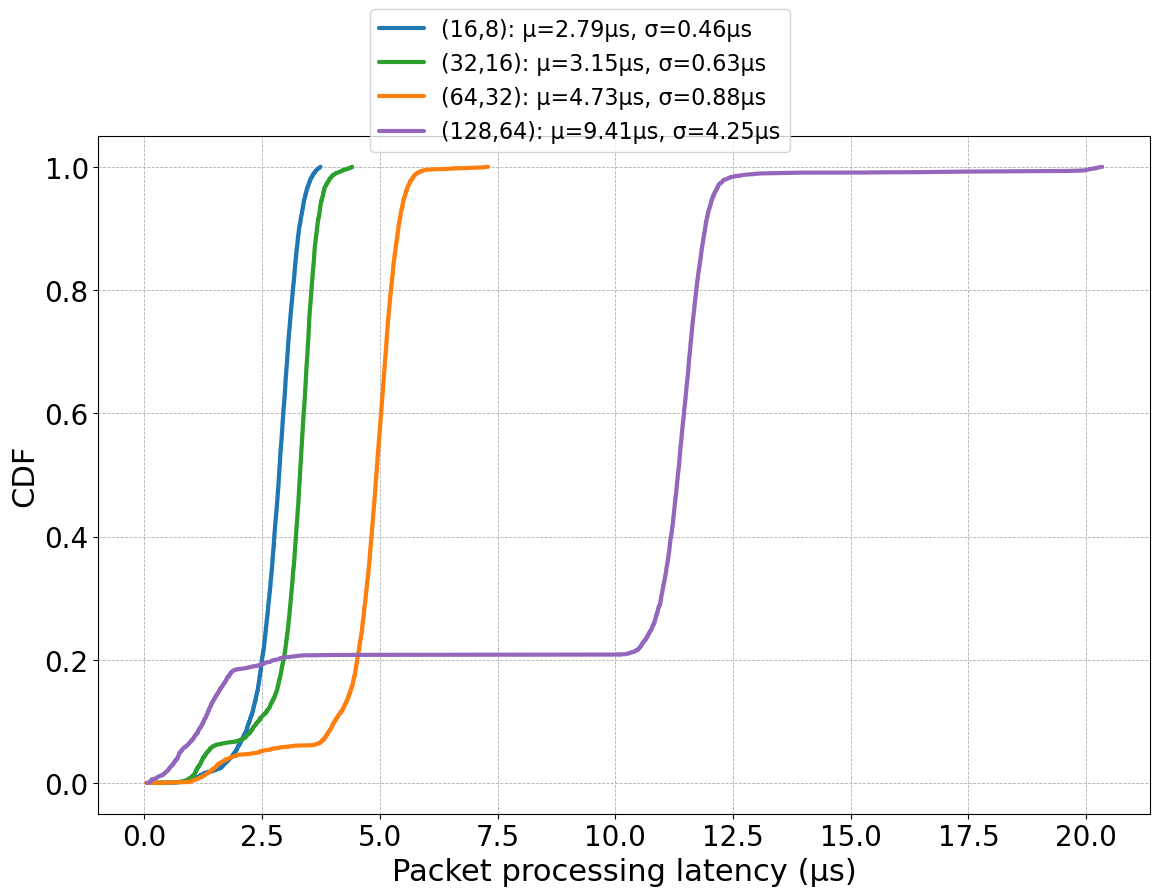


Summary (after removing >99th percentile):
  Model (16,8): mean = 2.7937 µs, std = 0.4633 µs
  Model (32,16): mean = 3.1506 µs, std = 0.6315 µs
  Model (64,32): mean = 4.7326 µs, std = 0.8803 µs
  Model (128,64): mean = 9.4129 µs, std = 4.2544 µs


In [99]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- user-editable ---
data_dir = "/home/ubuntu/DoH_DGA_training/notebooks/lat_scalar"   # path containing subfolders 16,32,64,128
models = ['16', '32', '64', '128']
tsc_hz = 300254821   # TSC frequency (Hz)
percentile_cut = 99  # remove values above this percentile (set to 99 to remove top 1%)
# ----------------------

colors = {
    '16': '#1f77b4',
    '32': '#2ca02c',
    '64': '#ff7f0e',
    '128': '#9467bd',
}

model_label_map = {
    '16': '(16,8)',
    '32': '(32,16)',
    '64': '(64,32)',
    '128': '(128,64)'
}

fig, ax = plt.subplots(figsize=(12,9))
plt.rcParams.update({'font.size': 20})  # set font size to 20

summary_stats = {}

def read_latencies(folder):
    fp = os.path.join(folder, "latencies_core0.csv")
    if not os.path.exists(fp):
        print(f"[WARN] Missing latencies file: {fp}")
        return None
    return pd.read_csv(fp)

def cycles_to_us(cycles, tsc_hz):
    # cycles * (1e6 / tsc_hz) gives microseconds
    return np.asarray(cycles, dtype=float) * (1e6 / float(tsc_hz))

for model in models:
    folder = os.path.join(data_dir, model)
    lat_df = read_latencies(folder)
    if lat_df is None or lat_df.empty:
        print(f"[INFO] Skipping model {model} (no latencies file).")
        continue

    # ensure required columns exist
    if not {'sample', 'cycles', 'ns'}.issubset(lat_df.columns):
        print(f"[WARN] latencies_core0.csv in {folder} missing required columns. Skipping.")
        continue

    # Convert cycles -> microseconds using tsc_hz
    packet_us_from_cycles = cycles_to_us(lat_df['cycles'].values, tsc_hz)

    # remove NaNs/Infs
    packet_us = pd.Series(packet_us_from_cycles).replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
    if packet_us.size == 0:
        print(f"[INFO] No valid packets for model {model}.")
        continue

    # remove top (100 - percentile_cut)% outliers (e.g. percentile_cut=95 removes top 5%)
    p_val = np.percentile(packet_us, percentile_cut)
    filtered = packet_us[packet_us <= p_val]
    if filtered.size == 0:
        print(f"[WARN] No data left after removing >{percentile_cut}th percentile for model {model}. Skipping.")
        continue

    # compute mean/std on filtered data
    mu = filtered.mean()
    sigma = filtered.std(ddof=0)
    summary_stats[model] = (mu, sigma)

    # Compute CDF using filtered values
    sorted_vals = np.sort(filtered)
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

    label = f"{model_label_map.get(model, model)}: µ={mu:.2f}µs, σ={sigma:.2f}µs"
    ax.plot(sorted_vals, cdf, label=label, color=colors.get(model), linewidth=3)

# Build legend and place it above the plot (like a title) with one entry per line
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.02),  # slightly above the top of the axes
           ncol=1,                      # stacked vertically
           fontsize=16,
           frameon=True)

# Formatting
ax.set_xlabel("Packet processing latency (µs)", fontsize=22)
ax.set_ylabel("CDF", fontsize=22)
ax.grid(True, which='both', linestyle='--', linewidth=0.6)

# leave room at the top for the legend
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()

print(f"\nSummary (after removing >{percentile_cut}th percentile):")
for m, (mu, sigma) in summary_stats.items():
    print(f"  Model {model_label_map.get(m, m)}: mean = {mu:.4f} µs, std = {sigma:.4f} µs")
